In [57]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV



 # Hyperparameters

In [58]:

CUSTOM_COLUMNS_TO_KEEP = [
    # "hour_cos",
    # "hour_sin",
    # "month_sin",
    # "month_cos",
    # "day-of-year",
]

COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
    "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    # "elevation:m",
    "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    # "date_calc",
    "pv_measurement",
    "date_forecast",
] + CUSTOM_COLUMNS_TO_KEEP

LOCATION = "C"

PV_SHIFTS = [
    # 30 * 24,
    # 60 * 24,
]
MODEL_FILENAME = f"models/xgboost_model_{LOCATION}.json"


 # Load Data

In [59]:
# 1. Load data
def load_and_combine_data():
    df_observed = pd.read_parquet(f"data/{LOCATION}/X_train_observed.parquet")
    df_estimated = pd.read_parquet(f"data/{LOCATION}/X_train_estimated.parquet")
    df_target = pd.read_parquet(f"data/{LOCATION}/train_targets.parquet")

    # print the span of dates in the estimated dataset
    print(
        f"Estimated dataset spans from {df_estimated['date_forecast'].min()} to {df_estimated['date_forecast'].max()}"
    )

    # 2. Combine observed and estimated datasets
    df_combined = pd.concat([df_observed, df_estimated], axis=0).sort_values(
        by="date_forecast"
    )

    df_resampled = df_combined.resample("H", on="date_forecast").mean()
    df_resampled = df_resampled.reset_index()
    # 3. Merge with target data
    df_merge = pd.merge(
        df_resampled, df_target, left_on="date_forecast", right_on="time", how="inner"
    )
    return df_merge


df_merged = load_and_combine_data()



Estimated dataset spans from 2022-10-28 22:00:00 to 2023-04-30 23:45:00
elevation:m
snow_density:kgm3


In [46]:
# Downsampling the dataframe to hourly intervals
# Add columns for hour of day, and month of year using sine and cosine to capture the cyclical nature
def add_custom_fields(df):
    df["hour_sin"] = np.sin(2 * np.pi * df["date_forecast"].dt.hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["date_forecast"].dt.hour / 24)

    df["month_sin"] = np.sin(2 * np.pi * df["date_forecast"].dt.month / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["date_forecast"].dt.month / 12)
    df["day-of-year"] = df["date_forecast"].dt.dayofyear
    return df


df_merged = add_custom_fields(df_merged)
# Keep only relevant columns
df_merged = df_merged[COLUMNS_TO_KEEP]

# 4. Extract features and target
df_merged = df_merged.dropna(subset=["pv_measurement"])
df_merged.fillna(0, inplace=True)  # Fill NaN values


 # Add lagged features

In [47]:
def add_lagged_features(df, features, shift_value):
    """
    This function takes in a dataframe, a list of features, and a shift interval.
    It returns the dataframe with the lagged features added.
    """
    for feature in features:
        if feature == "pv_measurement":
            df[f"{feature}_lagged_{shift_value}h"] = df[feature].shift(shift_value)
    return df


for shift in PV_SHIFTS:
    df_merged = add_lagged_features(df_merged, COLUMNS_TO_KEEP, shift)

# Remember to drop NaN values introduced by shifting
df_merged.dropna(inplace=True)



 # Remove outliers

In [48]:
# Remove outliers
def remove_outliers(df):
    """
    Removes outliers in a dataframe based on IQR for each column.

    Parameters:
    - df (DataFrame): input dataframe

    Returns:
    - DataFrame: dataframe with outliers removed
    """
    Q3 = df.quantile(0.95)
    IQR = Q3 - 0
    outlier_condition = ~((df < (0 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return df[outlier_condition].dropna()


# Remove outliers from the merged dataset
# df_merged = remove_outliers(df_merged)



 # Split Data into Train and Validation

In [49]:
# Split data
y = df_merged["pv_measurement"]
X = df_merged.drop(["pv_measurement", "date_forecast"], axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)


 # Baseline model

In [50]:


def naive_forecast(time_series, steps=1):
    """
    This function returns the time_series shifted by a given number of steps.
    For our purpose, we'll use 24-hour shift.
    """
    return time_series.shift(steps)


# Calculate the predictions using naive forecast
baseline_predictions = naive_forecast(y_train, steps=24)

# Only consider the predictions where both the actual and predicted values are available
mask = (~baseline_predictions.isna()) & (~y_train.isna())

# Calculate MAE
baseline_mae = np.mean(np.abs(baseline_predictions[mask] - y_train[mask]))
print(f"Baseline MAE: {baseline_mae}")


Baseline MAE: 45.88177999999999


 # XGBoost Model

In [51]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)


def train_model():
    # Modified XGBoost parameters to prevent overfitting
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "eta": 0.0005,
        "max_depth": 7,
        "subsample": 0.7,
        "colsample_bytree": 0.8,
        "min_child_weight": 7,
        "alpha": 0.4,
        "lambda": 1,
    }

    # Train XGBoost model with modifications
    num_rounds = 50000  # Increased boosting rounds due to reduced eta
    xgb_model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        evals=[(dtrain, "train"), (dval, "eval")],
        early_stopping_rounds=200,  # Increased early stopping rounds
        verbose_eval=10,
    )
    xgb_model.save_model(MODEL_FILENAME)

    return xgb_model


xgb_model = train_model()


[0]	train-mae:139.79326	eval-mae:117.86957
[10]	train-mae:139.20474	eval-mae:117.38554
[20]	train-mae:138.61840	eval-mae:116.90352
[30]	train-mae:138.03522	eval-mae:116.42905
[40]	train-mae:137.45435	eval-mae:115.95421
[50]	train-mae:136.87759	eval-mae:115.48155
[60]	train-mae:136.30253	eval-mae:115.01097
[70]	train-mae:135.73164	eval-mae:114.54825
[80]	train-mae:135.16333	eval-mae:114.08409
[90]	train-mae:134.59716	eval-mae:113.62114
[100]	train-mae:134.03512	eval-mae:113.16030
[110]	train-mae:133.47630	eval-mae:112.70458
[120]	train-mae:132.91988	eval-mae:112.25064
[130]	train-mae:132.36799	eval-mae:111.79940
[140]	train-mae:131.81862	eval-mae:111.34794
[150]	train-mae:131.27157	eval-mae:110.90238
[160]	train-mae:130.72785	eval-mae:110.45778
[170]	train-mae:130.18578	eval-mae:110.01433
[180]	train-mae:129.64671	eval-mae:109.57688
[190]	train-mae:129.11143	eval-mae:109.13985
[200]	train-mae:128.57741	eval-mae:108.69998
[210]	train-mae:128.04750	eval-mae:108.26822
[220]	train-mae:127.5

 # XGBoost Prediction and Evaluation

XGBoost MAE: 29.215043509081713
(6569,)


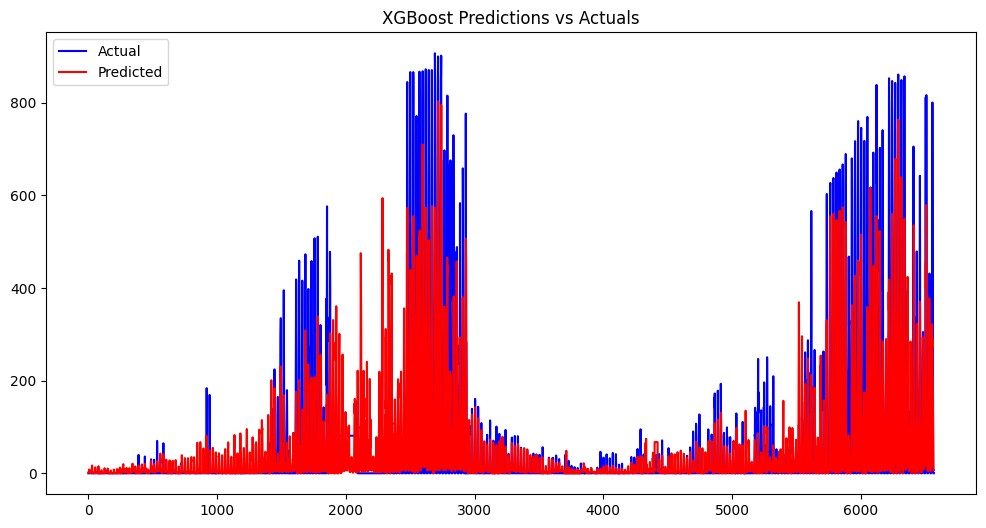

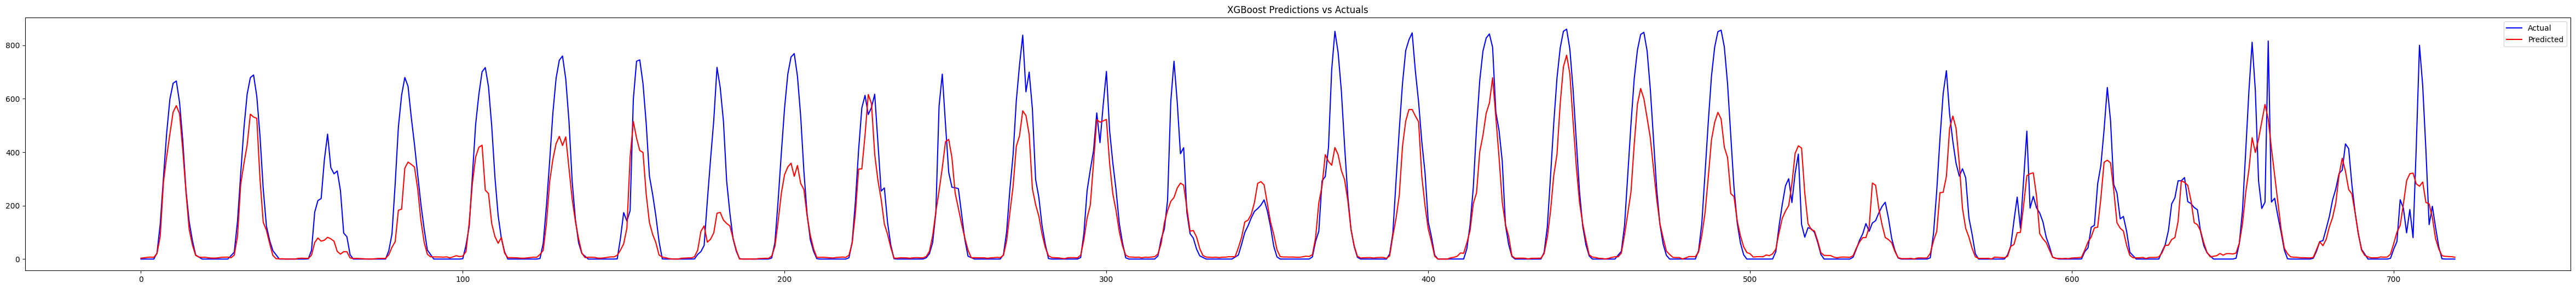

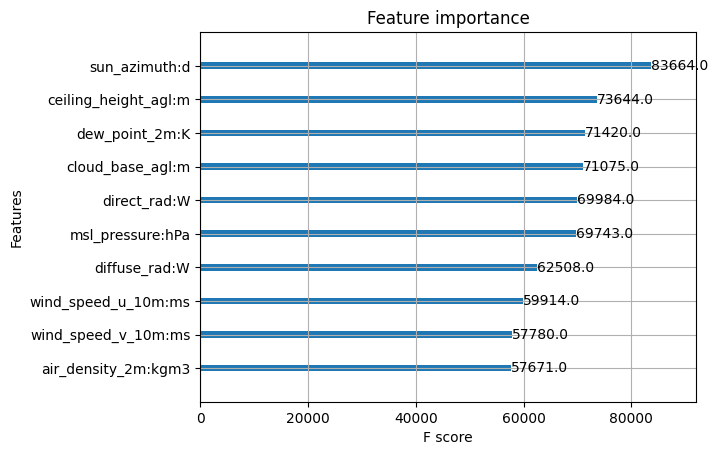

In [52]:

xgb_loaded_model = xgb.Booster()
xgb_loaded_model.load_model(MODEL_FILENAME)

# Predict with XGBoost
y_pred_xgb = xgb_loaded_model.predict(
    dval, iteration_range=(0, xgb_loaded_model.best_iteration + 1)
)
y_pred_xgb[y_pred_xgb < 0] = 0

# Calculate MAE for XGBoost
xgb_mae = np.mean(np.abs(y_pred_xgb - y_val))
print(f"XGBoost MAE: {xgb_mae}")

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_val.reset_index(drop=True), label="Actual", color="blue")
print(y_pred_xgb.shape)
plt.plot(y_pred_xgb, label="Predicted", color="red")
plt.title("XGBoost Predictions vs Actuals")
plt.legend()
plt.show()

plt.figure(figsize=(60, 6))
x_range = np.arange(720)
plt.plot(x_range, y_val.reset_index(drop=True).tail(720), label="Actual", color="blue")
plt.plot(x_range, y_pred_xgb.flatten()[-720:], label="Predicted", color="red")
plt.title("XGBoost Predictions vs Actuals")
plt.legend()
plt.show()

xgb.plot_importance(xgb_loaded_model, max_num_features=10)
plt.show()



 # Predict on test set

In [22]:
def load_model(location):
    model = xgb.Booster()
    model.load_model(f"models/xgboost_model_{location}.json")
    return model


def preprocess_test_data(df_test: pd.DataFrame):
    # add steps for combining the original training data before the test data, in order to keep shifted values
    df_test = add_custom_fields(df_test)
    df_test = df_test[COLUMNS_TO_KEEP]
    df_test.fillna(0, inplace=True)

    for shift in PV_SHIFTS:
        df_test = add_lagged_features(df_test, COLUMNS_TO_KEEP, shift)
    return df_test


def make_predictions(location, df_test):
    model = load_model(location)
    dtest = xgb.DMatrix(df_test)
    y_pred = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    y_pred[y_pred < 0] = 0
    return y_pred


# 2. Combine observed and estimated datasets
train_dataset = load_and_combine_data()

raw_test_dataset = pd.read_parquet(f"data/{LOCATION}/X_test_estimated.parquet")
raw_test_dataset = raw_test_dataset.resample("H", on="date_forecast").mean()
raw_test_dataset = raw_test_dataset.reset_index()


# 3. Merge train and raw dataset, so that we can use the same preprocessing
df_test = pd.concat([train_dataset, raw_test_dataset], axis=0).sort_values(
    by="date_forecast"
)

test_csv = pd.read_csv(f"data/test.csv")
# Get test_csv values only for the given location
test_csv = test_csv[test_csv["location"] == LOCATION]


test_dataset = preprocess_test_data(df_test)

test_dataset = test_dataset.loc[test_dataset["date_forecast"].isin(test_csv["time"])]
old_test_dataset = test_dataset.copy()
print(test_dataset.shape)
test_dataset = test_dataset.drop(["date_forecast"], axis=1)
print(test_dataset.shape)

# 4. predict
test_dataset.drop(["pv_measurement"], axis=1, inplace=True)
y_pred = make_predictions(LOCATION, test_dataset)

# 5. save predictions
old_test_dataset["pv_prediction"] = y_pred
old_test_dataset["LOCATION"] = LOCATION
old_test_dataset = old_test_dataset[["date_forecast", "pv_prediction", "LOCATION"]]
old_test_dataset.to_csv(f"predictions/{LOCATION}_xgboost.csv", index=False)



Estimated dataset spans from 2022-10-28 22:00:00 to 2023-04-30 23:45:00
(720, 51)
(720, 50)


/var/folders/z2/g8xyn7s12bg5v9jx9vpx997h0000gn/T/ipykernel_33844/1095896281.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.fillna(0, inplace=True)
/var/folders/z2/g8xyn7s12bg5v9jx9vpx997h0000gn/T/ipykernel_33844/838164508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_lagged_{shift_value}h"] = df[feature].shift(shift_value)
/var/folders/z2/g8xyn7s12bg5v9jx9vpx997h0000gn/T/ipykernel_33844/838164508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

 # Combine CSVs

In [10]:

def combine_location_files(a_file, b_file, c_file, output_file=None):
    # Load the files
    a_data = pd.read_csv(a_file)
    b_data = pd.read_csv(b_file)
    c_data = pd.read_csv(c_file)

    # Concatenate the data from the three files
    combined_data = pd.concat([a_data, b_data, c_data], ignore_index=True)

    # Sort by date_forecast and LOCATION
    combined_data = combined_data.sort_values(by=["LOCATION", "date_forecast"])

    # Create the delivery file structure
    delivery_file = pd.DataFrame(
        {"id": range(len(combined_data)), "prediction": combined_data["pv_prediction"]}
    )

    # Save to file if output_file is provided
    if output_file:
        delivery_file.to_csv(output_file, index=False)

    return delivery_file


# Example usage of the function to generate and save the combined delivery file
output_path = "predictions/combined_delivery_file.csv"
delivery_file = combine_location_files(
    "predictions/A_xgboost.csv",
    "predictions/B_xgboost.csv",
    "predictions/C_xgboost.csv",
    output_file=output_path,
)
delivery_file.head()



,id,prediction
0,0,1.122212
1,1,1.246590
2,2,1.408543
3,3,80.365974
4,4,352.384030


 # Compare with old delivery

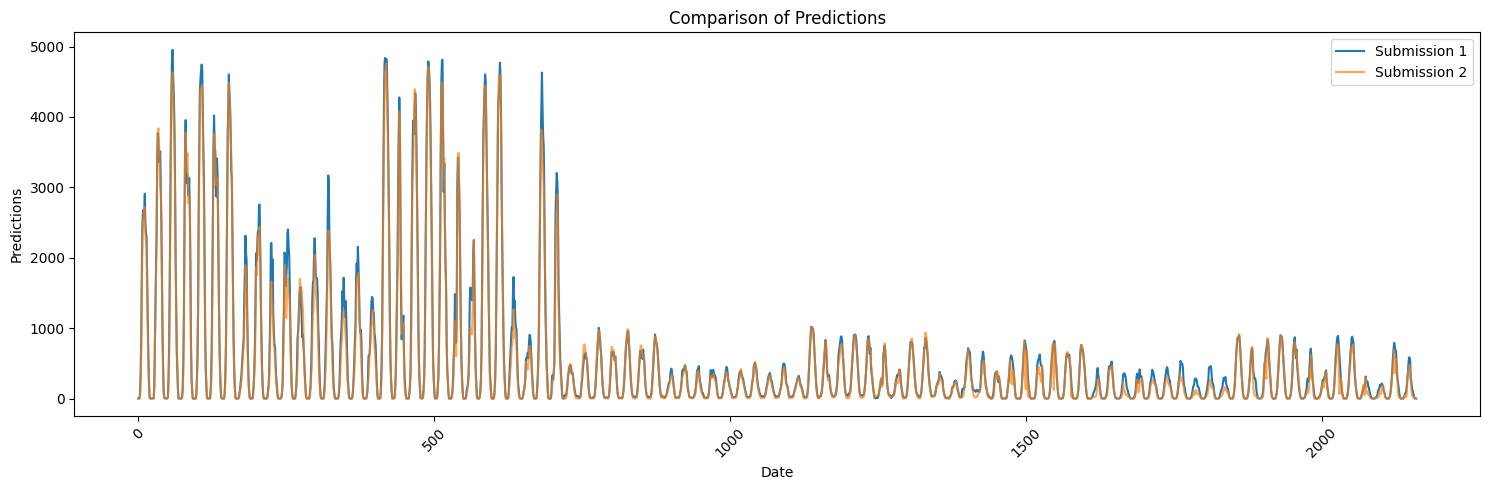

68.02401181924854


In [11]:
def calculate_mae(submission_file_1, submission_file_2):
    # Load the submission files
    sub_1 = pd.read_csv(submission_file_1)
    sub_2 = pd.read_csv(submission_file_2)

    # Check if both files have the same number of rows
    if len(sub_1) != len(sub_2):
        raise ValueError("The two submission files have different lengths.")

    # Compute the Mean Absolute Error
    mae = (sub_1["prediction"] - sub_2["prediction"]).abs().mean()

    return mae


def plot_comparisons(submission_file_1, submission_file_2):
    # Load the submission files
    sub_1 = pd.read_csv(submission_file_1)
    sub_2 = pd.read_csv(submission_file_2)

    # Merge the two DataFrames on the common key (assuming 'date_forecast' is the key)
    merged_sub = pd.merge(sub_1, sub_2, on="id", suffixes=("_1", "_2"))

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.plot(merged_sub["id"], merged_sub["prediction_1"], label="Submission 1")
    plt.plot(
        merged_sub["id"], merged_sub["prediction_2"], label="Submission 2", alpha=0.7
    )
    plt.title("Comparison of Predictions")
    plt.xlabel("Date")
    plt.ylabel("Predictions")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


# Calculate MAE between the two provided submission files
mae_value = calculate_mae(
    "predictions/combined_delivery_file.csv",
    "predictions_updated.csv",
)
plot_comparisons("predictions/combined_delivery_file.csv", "predictions_updated.csv")

print(mae_value)


 # XGBoost finding opptimal hyperparameters

In [ ]:
# Define the hyperparameter space
def optimize_xgb():
    param_grid = {
        "objective": ["reg:squarederror"],
        "eval_metric": ["mae"],
        "eta": [
            0.001,  # Best value I
            0.005,
            0.01,
            # 0.05,
            # 0.1,
            # 0.3,
        ],
        "max_depth": [
            # 3,
            # 4,
            # 5,
            6,
            7,  # Best value II
            8,
            # 9,
            # 10,
            # 12,
        ],
        "subsample": [
            # 0.3,
            # 0.4,
            # 0.5,
            # 0.6,
            0.7,  # Best value II
            0.8,  # Best value II
            0.9,
            # 1.0,
        ],
        "colsample_bytree": [
            # 0.3,
            # 0.4,
            # 0.5,
            # 0.6,
            0.7,
            0.8,  # Best value II
            0.9,  # Best value II
            # 1.0,
        ],
        "min_child_weight": [
            # 1,
            # 2,
            # 3,
            # 4,
            # 5,
            6,
            7,  # Best value III
            8,  # Best value I
            # 9,
            # 10,
            # 11,
            # 12,
        ],
    }

    # Initialize XGBoost Regressor
    xgb_optimization_model = xgb.XGBModel(
        learning_rate=0.02,
        n_estimators=600,
        objective="reg:squarederror",
        silent=True,
        nthread=1,
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        xgb_optimization_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=None,
        verbose=0,  # make it silent
        n_jobs=-1,
    )

    # Fit the model with early stopping rounds and validation data
    fit_params = {
        "early_stopping_rounds": 50,
        "eval_set": [(X_val, y_val)],
        "verbose": False,
    }

    grid_search.fit(X_train, y_train, **fit_params)

    # Print best parameters
    print("Best parameters found: ", grid_search.best_params_)

    # Predict on validation set
    y_pred_optimized = grid_search.predict(X_val)

    # Calculate MAE for optimized XGBoost
    mae_optimized = np.mean(np.abs(y_pred_optimized - y_val))
    print(f"Optimized XGBoost MAE: {mae_optimized}")

